Task

Subtask B: Conspiracy Category Classification : a system must discriminate which conspiracy theory a post supports. We consider four possible conspiracies:

In this competition, specific competition participants will tackle the SECOND of these two subtasks.

Covid Conspiracy: It is related to narratives concerning vaccine production, 5G, restrictions, and all kind of news intended to support the idea that the pandemic and actions taken by the government were useless instruments of control of the population.

Qanon Conspiracy: Qanon supported the idea that a group of Satanic Cannibalist sex abusers conspired against former U.S. President Donald Trump during his term of office. This theory extended far over the original scope embodying other beliefs that support (among the others) hate against women and the idea that a powerful elite (led by public figures like Pope Francis, Queen Elizabeth, and Hillary Clinton ) is trying to organize a New World Order.

Flat Earth: It is a theory that claims that Earth is flat. This theory deals also with discussions about UFO.

Pro-Russia Conspiracy: This theory supports the idea that in the Ukraine-Russia war, Ukraine and NATO supported by nazists soldiers hold the responsability of the war.

In [1]:
%pip install emoji sklearn pandas numpy nltk transformers torch matplotlib seaborn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

Documentazioni:
emoji: https://carpedm20.github.io/emoji/docs/

Il dataset presenta una lista di messaggi/post raccolti su vari social, una delle caratteristiche di queste forme di comunicazioni sono le emoticon (o emoji) e la forma del messaggio in se.
Questo significa che un testo che vuole catturare l'attenzione avrà un "titolo" d'impatto e spesso in maiuscolo, in quanto l'attenzione dedicata a questo tipo di contenuti è poca e di carattere transitorio.

Inoltre il dataset presenta una quantità di dati inadatta all'addestramento di un qualsiasi classficatore superabile tramite tecniche di data augmentation, questa caratteristica è intriseca nel problema in quanto i trend [^1] durano molto poco nel tempo e per un sistema di riconoscimento dei contenuti fuorvianti è necessario essere in grado di adattarsi in breve a queste variazioni.

Il dataset ha dimensione eterogenea, il che potrebbe portare a esempi per il transformer dove sono presenti lunghe stringhe di filler.






Di seguito verranno proposte alcune tecniche di preprocessing e di data augmentation


[^1]: Per trend si indica un argomento che cattura l'attenzione del pubblico e che ha orizzonte temporale molto breve, di solito nell'ordine dei giorni.

Possibili tentativi  

Data augmentation
- prendere solo i caratteri ripetuti o parole maiuscole e emoticon dal testo e verificare la label, questo può funzionare in quanto spesso la comunicazione passa per l'impatto della forma  
- utilizzare altri modelli di elaborazione del linguaggio, chiedendo di modificare il testo mantenendone il significato, nascondendone parti o riformulare in modo più o meno aggressivo la frase


Data preprocessing  
- Aggiungere una colonna che conta la percentuale di caratteri ripetuti o parole maiuscole ed una colonna con la presenza o meno di un set di emoji, per poi normalizzare il dataset trasformando in minuscolo tutti i caratteri  
- Raccolta di una percentuale della frase per raccogliere il "titolo" 

In [2]:
#from google.colab import drive

#drive.mount('/content/gdrive')
#root = '/content/gdrive/MyDrive/Colab Notebooks/dataset/'

root = './Dataset/'

In [3]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import time
from torch.optim import Adam
from torch import nn
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.utils import shuffle
import nltk
import matplotlib.pyplot as plt
import emoji
import copy
import pickle

In [4]:
#carica il dataset csv dal file presente in Dataset/subtaskA_train.cvs
dataset = pd.read_csv('Dataset/subtaskB_train.csv',  header=0, names=['text', 'explicit_label', 'label'])

dataset

,text,explicit_label,label
0,"Siamo davanti ad una prova, e non solo di quoz...",Qanon,1
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,Covid,0
2,L'avete capito che non toglieranno il green pa...,Covid,0
3,Quindi la farsa dello spazio e della terra a ...,Terra Piatta,3
4,"In breve tempo, per accedere a Internet, sarà ...",Qanon,1
...,...,...,...
805,"Incredibile!!!! EMA, Agenzia Europea del Farma...",Covid,0
806,Non ci saranno colloqui di pace con la Russia ...,Russia,2
807,"L'atmosfera è uno ""scudo protettivo"" che avvol...",Terra Piatta,3
808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,Covid,0


In [5]:
pd.set_option('display.max_colwidth', None)
color1 = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         )
color2 = (0.4, 0.2, 0.2, 0.6)
color3 = (0.6, 0.3, 0.1, 0.7)
color4 = (0.1, 0.5, 0.4, 0.5)
color5 = (0.8, 0.2, 0.3, 0.8)
colors = [color1, color2, color3, color4, color5]


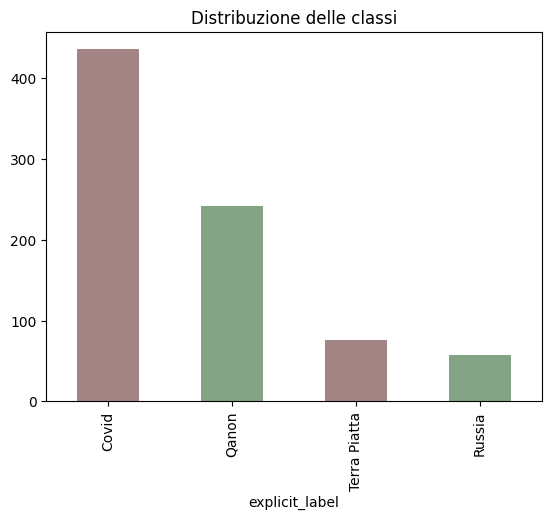

In [6]:
dataset['explicit_label'].value_counts().plot(kind='bar', color=[color2,color1])
plt.title('Distribuzione delle classi')
plt.show()

In [7]:
print("dati mancanti")
print(dataset.isna().sum())

dati mancanti
text              0
explicit_label    0
label             0
dtype: int64


In [8]:
explicit_label_from_index = ["Covid","Qanon","Terra Piatta", "Russia"]

In [9]:
def process_data_augmentation(dataset):
    typeA=['[Sinonimi]:','[Riassunto]:','[Tono diverso]:','[Parole chiave sostituite]:','[Domanda diretta]:']
    typeB=['Riscrivi il testo originale utilizzando sinonimi per esprimere lo stesso significato in italiano:','Fornisci un riassunto del testo originale in italiano:','Riscrivi il testo originale con un tono diverso, mantenendo però il medesimo significato in italiano:', 'Sostituisci alcune parole chiave nel testo originale in italiano:','Trasforma il testo originale in una domanda diretta in italiano:']
    processed_dataset = dataset.copy()
    processed_dataset = processed_dataset.drop(columns=['augmented_text'])
    augmented_dataset = pd.DataFrame(columns=['text', 'label'])
    #dataset['augmented_text'] = dataset['augmented_text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    for i in tqdm(range(len(dataset))):
        #Copio la singola riga del dataset in una variabile per usarla come stringa

        augmented = dataset.loc[i,'augmented_text']
        #Divido la stringa per riga
        augmented = augmented.split('\n')
        #Per ogni riga controllo se è presente una delle stringhe di tipo A o B
        #Esistono due tipi poiché i due modelli restituivano due strutture leggermente diverse
        for statement in augmented:
            #Verifico la riga appartenga al risultato e taglio la parte introduttiva
            for start in typeA:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    #Aggiungo la riga al dataset
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)
            for start in typeB:
                if start in statement:
                    augmented_dataset.loc[0,'text'] = statement.replace(start, '')
                    augmented_dataset.loc[0,'label'] = dataset.loc[i,'label']
                    processed_dataset = pd.concat([processed_dataset,augmented_dataset],ignore_index=True)

    processed_dataset['text'] = processed_dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

    return processed_dataset

In [10]:
augmented_dataset = pd.read_csv(f'{root}augmented_dataset2.csv',  header=0, names=['text', 'explicit_label', 'label','augmented_text'])
augmented_dataset = augmented_dataset.drop(columns=['explicit_label'])
augmented_dataset = process_data_augmentation(augmented_dataset)

  0%|          | 0/810 [00:00<?, ?it/s]

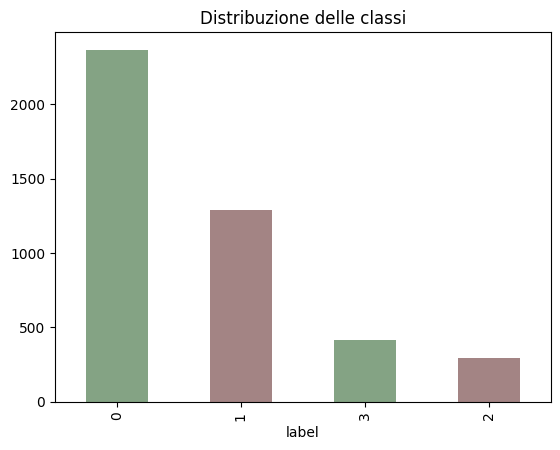

In [11]:
augmented_dataset['label'].value_counts().plot(kind='bar', color=[color1,color2])
plt.title('Distribuzione delle classi')
plt.show()

In [12]:
print("dati mancanti")
print(augmented_dataset.isna().sum())

dati mancanti
text     0
label    0
dtype: int64


In [13]:
augmented_dataset = shuffle(augmented_dataset, random_state=42)
augmented_dataset.head()

,text,label
1374,Il testo originale menziona un rapido resoconto dei piani del Deep State per disturbare l'equilibrio naturale della società e instaurarsi come normale.,1
2293,"CV19, anemia da immunizzazione e RISOLUTIVO universale! Mi lo assumo per altre ragioni e dopo circa sei mesi dirò di aver riscontrato reazioni positive su problematiche e inconvenienti che mi avevo trainato dietro da tempo.",0
3379,"Che azione chiede Luca Teodori, di M3V, riguardo la vaccinazione di massa e quale è la sua opinione sui motivi dietro a essa?",0
1090,Ho attendeva da decenni l'affermazione di questi fenomeni OVNI o OAV... E ho attendeva anche un video così... !!,3
1803,Quale evento è avvenuto il 15 aprile e come è stata descritta tale situazione?,0


In [14]:
def add_hashtag(dataset):
    augmented_dataset = dataset.copy()
    augmented_dataset['hashtag'] = ' '
    data = []

    for i in tqdm(range(len(dataset)), desc= "Looking for hashtag"):
        text = dataset.loc[i,'text']
        dato = [k for k in text.split() if k.startswith("#")]
        data.append(dato)

    augmented_dataset['hashtag'] = data
    augmented_dataset['hashtag'] = augmented_dataset['hashtag'].apply(lambda x: " ".join(x).replace('#', ''))


    return augmented_dataset

In [15]:
augmented_dataset = add_hashtag(augmented_dataset)
augmented_dataset.head()

Looking for hashtag:   0%|          | 0/4368 [00:00<?, ?it/s]

,text,label,hashtag
1374,Il testo originale menziona un rapido resoconto dei piani del Deep State per disturbare l'equilibrio naturale della società e instaurarsi come normale.,1,
2293,"CV19, anemia da immunizzazione e RISOLUTIVO universale! Mi lo assumo per altre ragioni e dopo circa sei mesi dirò di aver riscontrato reazioni positive su problematiche e inconvenienti che mi avevo trainato dietro da tempo.",0,
3379,"Che azione chiede Luca Teodori, di M3V, riguardo la vaccinazione di massa e quale è la sua opinione sui motivi dietro a essa?",0,
1090,Ho attendeva da decenni l'affermazione di questi fenomeni OVNI o OAV... E ho attendeva anche un video così... !!,3,
1803,Quale evento è avvenuto il 15 aprile e come è stata descritta tale situazione?,0,


In [16]:
hyperparameters = {
    "#_classes" : 4,
    "epochs": 40,
    "learning_rate": 1e-6,
    "batch_size": 3,
    "dropout": 0.1,
    "stopwords": False,
    "h_dim": 768,
    "patience": 10,
    "min_delta": 0.01,
    "language_model": "bert-base-multilingual-cased",
    "extra_features": 32, #32 hashtag
}

In [17]:
(x_train, x_test, hashtag_train, hashtag_test,y_train, y_test) = train_test_split(augmented_dataset['text'], augmented_dataset['hashtag'],augmented_dataset['label'], test_size=0.2, random_state=42)

(x_train, x_val, hashtag_train, hashtag_val, y_train, y_val) = train_test_split( x_train,hashtag_train, y_train, test_size=0.1, random_state=42)

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, hashtag, y, stopwords):


        tokens_litt = [nltk.word_tokenize(text, language='italian') for text in list(x)]

        text_clean = []

        for sentence in tqdm(tokens_litt, desc='Tokenizing text ... '):
            text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("italian")]))


        self.texts = [text for text in text_clean]
        self.hashtag = [h for h in hashtag]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def get_batch_hashtag(self, idx):
        # Fetch a batch of inputs
        return self.hashtag[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        batch_hashtag = self.get_batch_hashtag(idx)

        return batch_texts, batch_labels, batch_hashtag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
train_dataset = Dataset(x_train,hashtag_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val,hashtag_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test,hashtag_test, y_test, hyperparameters["stopwords"])

Tokenizing text ... :   0%|          | 0/3144 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/350 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/874 [00:00<?, ?it/s]

In [20]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping
        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza

In [21]:
class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout, model_name,extra_features = hyperparameters['extra_features']):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)
        self.classifier = nn.Sequential(
            nn.Linear(hdim + extra_features, 512),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(128, labels),
            )

    def forward(self, input_id_text, attention_mask, hashtag):
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:,0,:]
        output = torch.cat((output, hashtag), dim=1)  # Concatena il conteggio dei caratteri
        return self.classifier(output)

In [22]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels, hashtag in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()
        tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 400, truncation=True)
        tokens_hashtag = tokenizer(list(hashtag), add_special_tokens=True,
                            return_tensors='pt', padding='max_length',
                            max_length = 32, truncation=True)

        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)

        input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
        mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)
        
        batch_labels = batch_labels.to(device)

        output = model(input_id_texts, mask_texts, input_id_hashtag)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).float().mean()
        
        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()


    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [23]:
def test_loop(model, dataloader, tokenizer, loss, device, best_acc, best_weights):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, hashtag in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                               return_tensors='pt', padding='max_length',
                               max_length = 512, truncation=True)

            tokens_hashtag = tokenizer(list(hashtag), add_special_tokens=True,
                                return_tensors='pt', padding='max_length',
                                max_length = 32, truncation=True)

            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)

            input_id_hashtag = tokens_hashtag['input_ids'].squeeze(1).to(device)
            mask_hashtag = tokens_hashtag['attention_mask'].squeeze(1).to(device)

            batch_labels = batch_labels.to(device)


            output = model(input_id_texts, mask_texts, input_id_hashtag)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).float().mean()
            

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()
        acc = float(epoch_acc/len(dataloader))
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())


    return epoch_loss/len(dataloader), epoch_acc/len(dataloader), best_acc, best_weights

In [24]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, language_model, train_loss_fn, test_loss_fn=None,
               early_stopping=None, val_data=None, scheduler=None):

  train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    # check sulle funzioni di loss
  if test_loss_fn == None:
    test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
  train_loss = []
  validation_loss = []
  test_loss = []

  train_acc = []
  validation_acc = []
  test_acc = []
  best_acc = - np.inf
  best_weights = None
  tokenizer = AutoTokenizer.from_pretrained(language_model)

    # Ciclo di addestramento con early stopping
  for epoch in tqdm(range(1,epochs+1)):
    epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
    if early_stopping != None:
      epoch_validate_loss, epoch_validate_acc, best_acc, best_weights = test_loop(model,
                                val_dataloader, tokenizer, test_loss_fn, device, best_acc, best_weights)
      validation_loss.append(epoch_validate_loss)
      validation_acc.append(epoch_validate_acc/len(val_data))

        # test
    epoch_test_loss, epoch_test_acc, best_acc, best_weights = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device, best_acc, best_weights)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc/len(test_data))

    val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
    val_acc_str = f'Validation accuracy: {(epoch_validate_acc):6.4f} ' if early_stopping != None else ' '
    print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
    print(f"Train accuracy: {(epoch_train_acc):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc):6.4f}")
    # early stopping
    if early_stopping != None:
      early_stopping(epoch_validate_loss)
      if early_stopping.early_stop:
        break

  return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc, best_acc, best_weights

In [25]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")
#La funzione di loss va modificata in base al parametro #_classes
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])

Using cuda device
ClassifierDeep(
  (lm_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [26]:
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc, best_acc, best_weights = train_test(
                                                model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                
                                               )
with open("best_weight.pkl", 'wb') as f:
  pickle.dump(best_weights, f)



  0%|          | 0/40 [00:00<?, ?it/s]

training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 3.1486  Test loss: 3.0456
Train accuracy: 0.4641  Test accuracy: 0.6210


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 2.1978  Test loss: 2.6893
Train accuracy: 0.7112  Test accuracy: 0.7922


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.6945  Test loss: 2.5788
Train accuracy: 0.8028  Test accuracy: 0.8368


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.5892  Test loss: 2.4860
Train accuracy: 0.8483  Test accuracy: 0.8607


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.1656  Test loss: 2.4190
Train accuracy: 0.8810  Test accuracy: 0.8733


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 1.0961  Test loss: 2.4036
Train accuracy: 0.9078  Test accuracy: 0.8744


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.8502  Test loss: 2.3523
Train accuracy: 0.9291  Test accuracy: 0.8779


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.9768  Test loss: 2.3214
Train accuracy: 0.9370  Test accuracy: 0.8836


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.6039  Test loss: 2.2816
Train accuracy: 0.9469  Test accuracy: 0.8927


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.6597  Test loss: 2.2609
Train accuracy: 0.9513  Test accuracy: 0.9007


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.5369  Test loss: 2.2556
Train accuracy: 0.9571  Test accuracy: 0.8881


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.5135  Test loss: 2.2255
Train accuracy: 0.9596  Test accuracy: 0.8950


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4980  Test loss: 2.2060
Train accuracy: 0.9656  Test accuracy: 0.9064


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.7313  Test loss: 2.2108
Train accuracy: 0.9682  Test accuracy: 0.9053


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.5022  Test loss: 2.1740
Train accuracy: 0.9691  Test accuracy: 0.9098


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4063  Test loss: 2.2417
Train accuracy: 0.9765  Test accuracy: 0.8984


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2599  Test loss: 2.2089
Train accuracy: 0.9758  Test accuracy: 0.9144


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3869  Test loss: 2.2256
Train accuracy: 0.9758  Test accuracy: 0.9041


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4665  Test loss: 2.2421
Train accuracy: 0.9787  Test accuracy: 0.9007


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4205  Test loss: 2.2127
Train accuracy: 0.9803  Test accuracy: 0.9144


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3210  Test loss: 2.1901
Train accuracy: 0.9793  Test accuracy: 0.9155


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2057  Test loss: 2.1946
Train accuracy: 0.9781  Test accuracy: 0.9212


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2861  Test loss: 2.2158
Train accuracy: 0.9822  Test accuracy: 0.9110


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2966  Test loss: 2.2398
Train accuracy: 0.9819  Test accuracy: 0.9121


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3468  Test loss: 2.2819
Train accuracy: 0.9844  Test accuracy: 0.9121


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4510  Test loss: 2.2668
Train accuracy: 0.9825  Test accuracy: 0.9144


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2351  Test loss: 2.2319
Train accuracy: 0.9838  Test accuracy: 0.9167


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1237  Test loss: 2.2344
Train accuracy: 0.9847  Test accuracy: 0.9269


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3524  Test loss: 2.2514
Train accuracy: 0.9831  Test accuracy: 0.9235


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2476  Test loss: 2.2766
Train accuracy: 0.9844  Test accuracy: 0.9144


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.3214  Test loss: 2.2791
Train accuracy: 0.9857  Test accuracy: 0.9178


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.4225  Test loss: 2.2727
Train accuracy: 0.9812  Test accuracy: 0.9235


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2380  Test loss: 2.3040
Train accuracy: 0.9835  Test accuracy: 0.9190


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2273  Test loss: 2.3417
Train accuracy: 0.9844  Test accuracy: 0.9110


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1673  Test loss: 2.3425
Train accuracy: 0.9819  Test accuracy: 0.9167


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2046  Test loss: 2.3142
Train accuracy: 0.9854  Test accuracy: 0.9190


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.0722  Test loss: 2.3588
Train accuracy: 0.9876  Test accuracy: 0.9201


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2245  Test loss: 2.3784
Train accuracy: 0.9863  Test accuracy: 0.9178


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.1984  Test loss: 2.4332
Train accuracy: 0.9841  Test accuracy: 0.9041


training set:   0%|          | 0/1048 [00:00<?, ?it/s]

dev set:   0%|          | 0/292 [00:00<?, ?it/s]


Train loss: 0.2146  Test loss: 2.3938
Train accuracy: 0.9844  Test accuracy: 0.9155


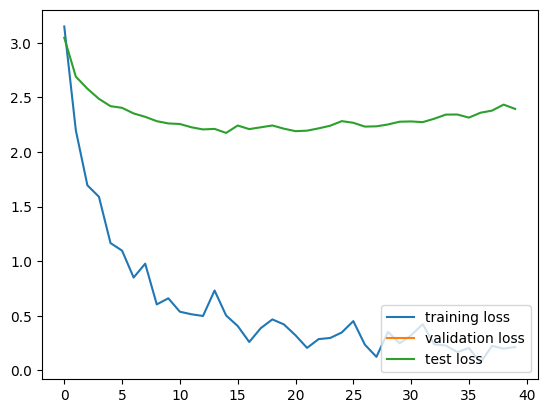

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

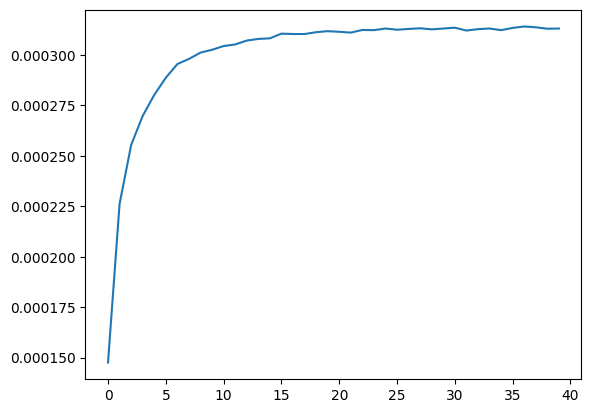

In [36]:
train_acc = [ np.array(x.cpu().float()) for x in train_acc ]
validation_acc = [ np.array(x.cpu().float()) for x in validation_acc ]
test_acc = [ np.array(x.cpu().float()) for x in test_acc ]


plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

In [42]:
dataset = pd.read_csv(f'{root}subtaskB_train.csv',  header=0,  names=['text', 'explicit_label', 'label'])
dataset = dataset.drop(columns=['explicit_label'])
dataset['text'] = dataset['text'].apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
dataset = add_hashtag(dataset)
dataset = shuffle(dataset, random_state=42)

(x_train_original_dataset, x_test_original_dataset, hashtag_train_original_dataset, hashtag_test_original_dataset,y_train_original_dataset, y_test_original_dataset) = train_test_split(dataset['text'], dataset['hashtag'] ,dataset['label'], test_size=0.2, random_state=42)

(x_train_original_dataset, x_val_original_dataset, hashtag_train_original_dataset, hashtag_val_original_dataset, y_train_original_dataset, y_val_original_dataset) = train_test_split( x_train_original_dataset,hashtag_train_original_dataset, y_train_original_dataset, test_size=0.1, random_state=42)

train_dataset_original_dataset = Dataset(x_train_original_dataset,hashtag_train_original_dataset, y_train_original_dataset, hyperparameters["stopwords"])
#val_dataset_original_dataset = Dataset(x_val_original_dataset,char_count_val_original_dataset,emoji_val_original_dataset,hashtag_val_original_dataset, y_val_original_dataset, hyperparameters["stopwords"])
test_dataset_original_dataset = Dataset(x_test_original_dataset,hashtag_test_original_dataset, y_test_original_dataset, hyperparameters["stopwords"])


model = ClassifierDeep(hyperparameters["#_classes"],
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"],
                    hyperparameters["language_model"]).to(device)

#La funzione di loss va modificata in base al parametro #_classes
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])


train_loss_original_dataset, validation_loss_original_dataset,test_loss_original_dataset, train_acc_original_dataset, validation_acc_original_dataset, test_acc_original_dataset, best_acc, best_weights = train_test(
                                                model,
                                                hyperparameters['epochs'],
                                                optimizer,
                                                device,
                                                train_dataset_original_dataset,
                                                test_dataset_original_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                                None,
                                                None)
with open("best_weight_original.pkl", 'wb') as f:
  pickle.dump(best_weights, f)


Looking for hashtag:   0%|          | 0/810 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/583 [00:00<?, ?it/s]

Tokenizing text ... :   0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 4.1891  Test loss: 1.2619
Train accuracy: 0.2291  Test accuracy: 0.3148


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 4.1891  Test loss: 1.1588
Train accuracy: 0.4598  Test accuracy: 0.5185


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.7276  Test loss: 1.1201
Train accuracy: 0.5197  Test accuracy: 0.5123


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.3808  Test loss: 1.0795
Train accuracy: 0.5214  Test accuracy: 0.5185


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.9967  Test loss: 1.0172
Train accuracy: 0.5675  Test accuracy: 0.5617


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.4776  Test loss: 0.9476
Train accuracy: 0.6188  Test accuracy: 0.6420


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.8410  Test loss: 0.8639
Train accuracy: 0.6564  Test accuracy: 0.7222


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 4.3882  Test loss: 0.7773
Train accuracy: 0.7778  Test accuracy: 0.7716


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.6747  Test loss: 0.7199
Train accuracy: 0.8205  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.6746  Test loss: 0.6777
Train accuracy: 0.8615  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.2739  Test loss: 0.6409
Train accuracy: 0.8650  Test accuracy: 0.8025


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.5924  Test loss: 0.6263
Train accuracy: 0.9128  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.3981  Test loss: 0.6019
Train accuracy: 0.9316  Test accuracy: 0.8148


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.3151  Test loss: 0.6200
Train accuracy: 0.9470  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.4782  Test loss: 0.6085
Train accuracy: 0.9658  Test accuracy: 0.7840


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 3.6713  Test loss: 0.5964
Train accuracy: 0.9624  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.3970  Test loss: 0.5948
Train accuracy: 0.9812  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.6269  Test loss: 0.5719
Train accuracy: 0.9709  Test accuracy: 0.8025


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.5994  Test loss: 0.5757
Train accuracy: 0.9863  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.4241  Test loss: 0.6061
Train accuracy: 0.9812  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.6979  Test loss: 0.5946
Train accuracy: 0.9863  Test accuracy: 0.7840


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 2.0432  Test loss: 0.6058
Train accuracy: 0.9915  Test accuracy: 0.7716


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.8768  Test loss: 0.6441
Train accuracy: 0.9915  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.4588  Test loss: 0.5908
Train accuracy: 0.9949  Test accuracy: 0.8025


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.3174  Test loss: 0.6128
Train accuracy: 0.9932  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.2596  Test loss: 0.6209
Train accuracy: 0.9966  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.2517  Test loss: 0.7122
Train accuracy: 0.9880  Test accuracy: 0.7654


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.7123  Test loss: 0.6173
Train accuracy: 0.9949  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.6960  Test loss: 0.6631
Train accuracy: 0.9812  Test accuracy: 0.7840


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.5202  Test loss: 0.6423
Train accuracy: 0.9949  Test accuracy: 0.8025


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.2426  Test loss: 0.6689
Train accuracy: 0.9932  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.5219  Test loss: 0.6566
Train accuracy: 0.9932  Test accuracy: 0.8025


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.3120  Test loss: 0.7161
Train accuracy: 0.9915  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.8817  Test loss: 0.6820
Train accuracy: 0.9966  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.4751  Test loss: 0.6931
Train accuracy: 0.9983  Test accuracy: 0.7778


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.7758  Test loss: 0.6824
Train accuracy: 0.9949  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.1331  Test loss: 0.6928
Train accuracy: 0.9983  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.4580  Test loss: 0.6999
Train accuracy: 0.9966  Test accuracy: 0.7901


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 0.0764  Test loss: 0.7009
Train accuracy: 0.9983  Test accuracy: 0.7963


training set:   0%|          | 0/195 [00:00<?, ?it/s]

dev set:   0%|          | 0/54 [00:00<?, ?it/s]


Train loss: 1.0506  Test loss: 0.7221
Train accuracy: 0.9966  Test accuracy: 0.7963


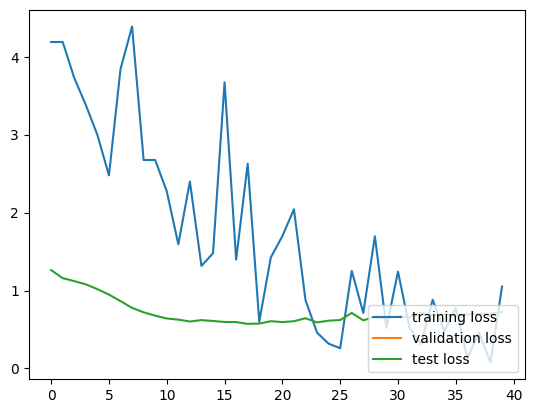

In [43]:
plt.plot(train_loss_original_dataset, label='training loss')
plt.plot(validation_loss_original_dataset, label='validation loss')
plt.plot(test_loss_original_dataset, label='test loss')
plt.legend(loc='lower right')
plt.show()

In [62]:
train_acc_original_dataset = [ np.array(x.cpu().float()) for x in train_acc_original_dataset ]
validation_acc_original_dataset = [ np.array(x.cpu().float()) for x in validation_acc_original_dataset ]
test_acc_original_dataset = [ np.array(x.cpu().float()) for x in test_acc_original_dataset ]

plt.plot(train_acc_original_dataset, label='training accuracy')
plt.plot(validation_acc_original_dataset, label='validation accuracy')
plt.plot(test_acc_original_dataset, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()

AttributeError: 'float' object has no attribute 'cpu'